## 단일 에이전트로 ChatGPT 만들어 보기
코드 어시스턴트

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from datetime import datetime
from typing import Annotated, TypedDict
from pydantic import BaseModel, Field

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

from openai import OpenAI

from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

### 이미지 생성도구

In [3]:
client = OpenAI()

# DALL-E 이미지 생성을 위한 스키마 정의
class GenImageSchema(BaseModel):
    prompt: str = Field(description="The prompt for image generation")

# DALL-E 이미지 생성 함수 정의
@tool(args_schema=GenImageSchema)
def generate_image(prompt: str) -> str:
    """
    Generate an image using DALL-E based on the given prompt.
    """
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

### 코드 실행 도구 정의

In [4]:
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code.
    This is visible to the user. Please use ploly to visualize."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

### 에이전트 정의

In [5]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

system_prompt = f"""
Today is {datetime.now().strftime("%Y-%m-%d")}
You are a helpful AI Assistant that can use web search tool(tavily ai api), image generation tool(DallE API) and code execution tool(Python REPL).
You should always answer in same language as user's ask.
When user ask about the information that you can't answer, you can call the search tool.
When user ask about generating image, you can call the generate_image tool.
When user ask about Data analysis, data visualization or code execution image, you can call the python repl tool.
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

search = TavilySearchResults(max_results=5)

tools = [search, generate_image, python_repl]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_52565/2642603390.py:20: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=5)


In [6]:
result = chain.invoke("대한민국 GDP 추이를 그래프로 그려줘")
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_dE3CIefN4557LTgQZKXVr6VZ', 'function': {'arguments': '{"query":"대한민국 GDP 추이 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 282, 'total_tokens': 307, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--2821fa85-4bce-4bd9-8309-2f0a7884423f-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 GDP 추이 2025'}, 'id': 'call_dE3CIefN4557LTgQZKXVr6VZ', 'type': 'tool_call'}] usage_metadata={'input_tokens': 282, 'output_tokens': 25, 'total_tokens': 307, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

In [7]:
result.additional_kwargs['tool_calls']

[{'id': 'call_dE3CIefN4557LTgQZKXVr6VZ',
  'function': {'arguments': '{"query":"대한민국 GDP 추이 2025"}',
   'name': 'tavily_search_results_json'},
  'type': 'function'}]

### 그래프 생성

In [8]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

================================ Human Message =================================

대한민국 GDP 추이를 그래프로 그려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_sxFZOsD1mREDfZRD1oylszFL)
 Call ID: call_sxFZOsD1mREDfZRD1oylszFL
  Args:
    query: 대한민국 GDP 추이 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "대한민국 GDP | 1960-2023 데이터 | 2024-2025 예상 - 경제 지표", "url": "https://ko.tradingeconomics.com/south-korea/gdp", "content": "### 2025년 말까지 한국의 GDP는 Trading Economics의 글로벌 마크로 모델과 분석가들의 기대에 따르면 1742.00억 달러에 이를 것으로 예상됩니다. 장기적으로 한국의 GDP는 우리의 계량 경제 모델에 따르면 2026년에는 약 1782.00억 달러, 2027년에는 1830.00억 달러로 추이할 것으로 예측됩니다. [...] ##### \n\n# 대한민국 GDP1960-2023 데이터 | 2024-2025 예상\n\n## 대한민국의 국내총생산(GDP)은 2023년 기준으로 세계은행의 공식 데이터에 따르면 1,712.79 십억 미국 달러에 해당합니다. 대한민국의 GDP 가치는 세계 경제의 1.62%를 나타냅니다. 대한민국의 GDP는 1960년부터 2023년까지 평균 558.23억 미국 달러로, 2021년에는 역대 최고치인 1

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Tool Calls:
  python_repl (call_dkW2aQDVcBK4eJrLt4VZY1L7)
 Call ID: call_dkW2aQDVcBK4eJrLt4VZY1L7
  Args:
    code: import matplotlib.pyplot as plt
import pandas as pd

# 대한민국 GDP 데이터
years = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2023, 2025]
gdp_values = [2.42, 8.1, 63.8, 263.8, 576.1, 1094.5, 1631.4, 1712.79, 1742.0]  # 십억 달러 단위

# 데이터프레임 생성
korea_gdp = pd.DataFrame({'Year': years, 'GDP (Billion USD)': gdp_values})

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(korea_gdp['Year'], korea_gdp['GDP (Billion USD)'], marker='o')
plt.title('대한민국 GDP 추이 (1960-2025)')
plt.xlabel('연도')
plt.ylabel('GDP (십억 달러)')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()


<string>:19: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 49901 (\N{HANGUL SYLLABLE SIB}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
<string>:19: UserWar

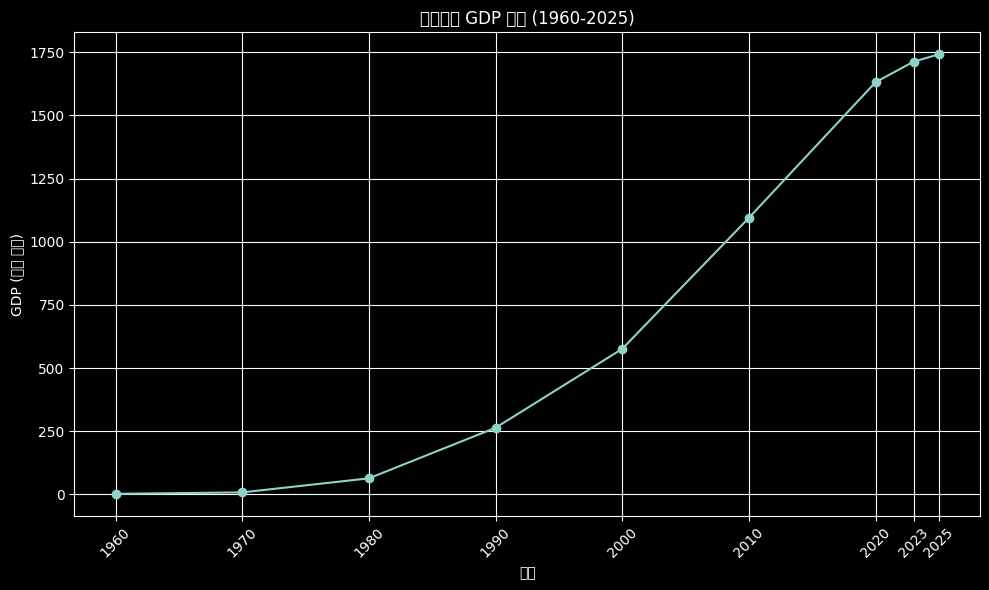

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt
import pandas as pd

# 대한민국 GDP 데이터
years = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2023, 2025]
gdp_values = [2.42, 8.1, 63.8, 263.8, 576.1, 1094.5, 1631.4, 1712.79, 1742.0]  # 십억 달러 단위

# 데이터프레임 생성
korea_gdp = pd.DataFrame({'Year': years, 'GDP (Billion USD)': gdp_values})

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(korea_gdp['Year'], korea_gdp['GDP (Billion USD)'], marker='o')
plt.title('대한민국 GDP 추이 (1960-2025)')
plt.xlabel('연도')
plt.ylabel('GDP (십억 달러)')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()
```
Stdout: 


KeyboardInterrupt: 

In [9]:
# The config is the **second positional argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()